In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from tqdm import tqdm
from torch.utils.data import Dataset

import os
import tifffile
import trackpy as tp


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Load Data

In [22]:
def get_PSF_frame(movie_frame, x, y, frame_size, keep_edges=False):
    half_frame = int(frame_size/2)
    int_x = round(x); int_y = round(y)
    lower_x = int_x - half_frame
    lower_y = int_y - half_frame
    upper_x = int_x + half_frame + 1
    upper_y = int_y + half_frame + 1
    upper_limit_x = movie_frame.shape[1]
    upper_limit_y = movie_frame.shape[0]
    if keep_edges:
        if lower_x < 0:
            lower_x = 0
        if lower_y < 0:
            lower_y = 0
        if upper_x > upper_limit_x:
            upper_x = upper_limit_x
        if upper_y > upper_limit_y:
            upper_y = upper_limit_y
    else:
        if lower_x < 0 or lower_y < 0 or upper_x > upper_limit_x or upper_y > upper_limit_y:
            return False
    return np.array(movie_frame)[lower_y:upper_y, lower_x:upper_x]

def get_PSF_frames(movie, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9, to_plot=False, movie_frames=True, dpi=100):
    if type(movie_frames) == bool:
        movie_frames = range(len(movie))
    
    # Initialize an empty list to store the PSF frames
    PSF_frames = []

    # Loop through each frame in the movie
    for i in movie_frames:
        # Perform localization on the frame
        full_frame = tp.locate(movie[i], diameter=diameter, 
                        minmass=minmass, max_iterations=10,
                        separation=separation, percentile=percentile)  # Adjust the minmass parameter as needed

        # Plot the frame with the identified features
        if to_plot:
            fig, ax = plt.subplots(1, dpi=dpi)
            ax.imshow(movie[i], cmap='gray')

        # Draw a box around each identified feature
        for index, row in full_frame.iterrows():
            if to_plot:
                rect = patches.Rectangle((row['x']-int(frame_size/2), row['y']-int(frame_size/2)), frame_size, frame_size, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            PSF_frame = get_PSF_frame(movie[i], row['x'], row['y'], frame_size)
            if type(PSF_frame) == bool:
                continue
            PSF_frames.append(PSF_frame)
        if to_plot:
            plt.title(f'Full Frame {i}')
            plt.show()

    # Convert the list of frames to a numpy array
    PSF_frames = np.array(PSF_frames)
    return PSF_frames

def get_PSF_frames_movie_list(movies, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9):
    first = True
    for movie in movies:
        if first:
            PSF_list = get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)
            first = False
        else:
            PSF_list = np.concatenate((PSF_list, get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)))
    return PSF_list

def show_PSFs(PSF_frames, random=True):
    print(PSF_frames.shape)
    num_PSFs = 15
    if not random:
        random_seed = 1 # random seed for reproducibility
        np.random.seed(random_seed)
    PSF_indices = np.random.choice(PSF_frames.shape[0], size=num_PSFs, replace=False)
    image_list = PSF_frames[PSF_indices]

    # Creating a 2x5 subplot grid
    fig, axes = plt.subplots(3, 5, figsize=(10, 4), dpi=150)

    # Flattening the 2D array of axes to a 1D array
    axes = axes.flatten()

    # Iterating over each image and corresponding axis
    for i in range(len(axes)):
        # Displaying the image on the corresponding axis
        axes[i].imshow(image_list[i], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Examples of PSF Frames", fontsize=24)
    plt.tight_layout()
    plt.show()

def load_tif_movies(folder_path):
    movies = []
    for filename in os.listdir(folder_path):
        # Check if the current file is a .tif file
        if filename.endswith('.tif'):
            # Construct the full filepath by joining the directory path and the filename
            filepath = os.path.join(folder_path, filename)
            movies.append(tifffile.imread(filepath))
    return movies


## Tons of Data for Training

In [9]:
A647_movies = load_tif_movies('Raw Data\A647')
CF660_movies = load_tif_movies('Raw Data\CF660c')
print(len(A647_movies), len(CF660_movies))

<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing

8 12


In [15]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
A647_PSFs = get_PSF_frames_movie_list(A647_movies, minmass, separation, diameter, frame_size, percentile)

c:\ProgramData\anaconda3\envs\PyTorch\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
c:\ProgramData\anaconda3\envs\PyTorch\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
c:\ProgramData\anaconda3\envs\PyTorch\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass c

(199604, 19, 19)


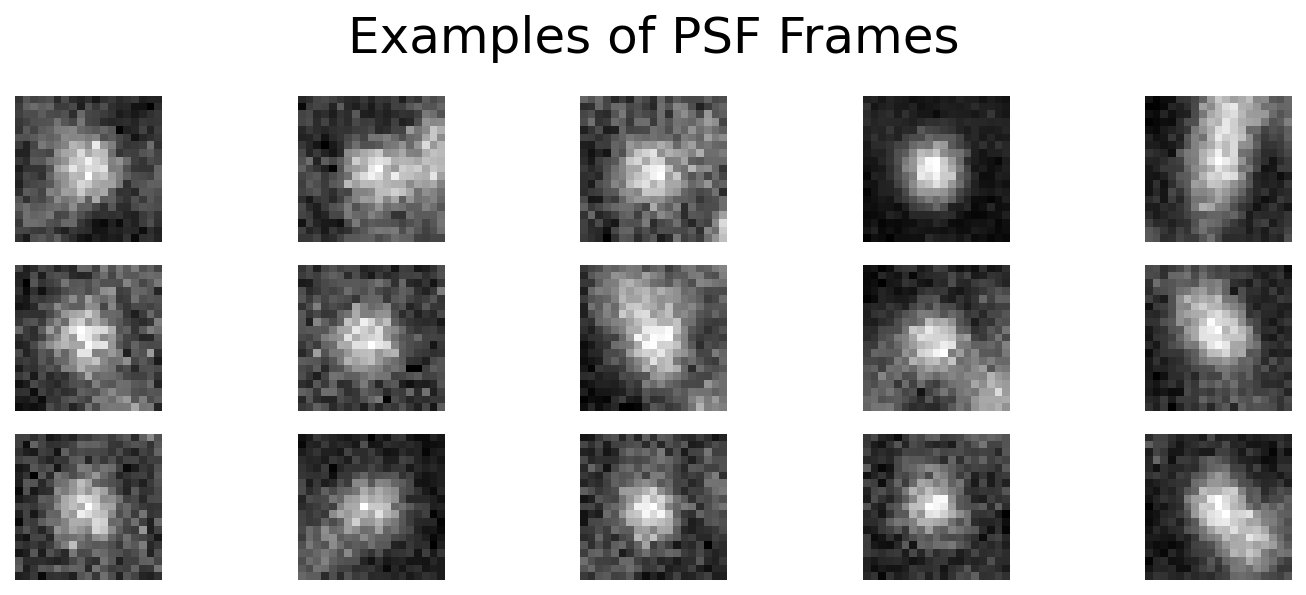

In [36]:
show_PSFs(A647_PSFs)

In [37]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
CF660_PSFs = get_PSF_frames_movie_list(CF660_movies, minmass, separation, diameter, frame_size, percentile)

c:\ProgramData\anaconda3\envs\PyTorch\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
c:\ProgramData\anaconda3\envs\PyTorch\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
c:\ProgramData\anaconda3\envs\PyTorch\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass c

(99769, 19, 19)


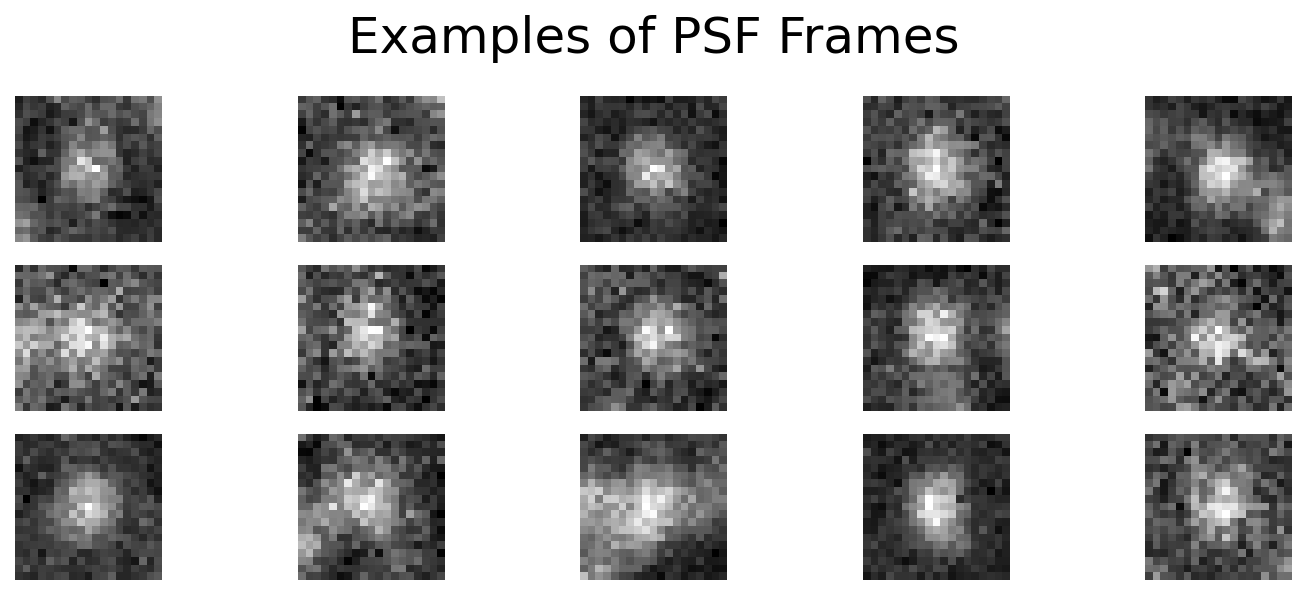

In [46]:
show_PSFs(CF660_PSFs)

In [47]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSFs
B_raw = CF660_PSFs

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [48]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices))]]).long().cuda()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[int(split*len(all_indices)):]]).long().cuda()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]

# make training set
PSF_training = PSFDataset(True)
# make testing set
PSF_testing = PSFDataset(False)

print(len(PSF_training))
print(len(PSF_testing))

169607
29931


## Good Data for Post-Training Testing

In [49]:
# Load the TIFF movie for Good Data
A647_movie = tifffile.imread('Raw Data\Good Data\A647-GoatAntiMouse-No1CG-100EMG-50ms_28mW.tif')
CF660_movie = tifffile.imread('Raw Data\Good Data\CF660c-GaM_No1CG_100EMG_50ms_28mW647_0mW405.tif')
print(f"A647 Frame Count: {len(A647_movie)}")
print(f"CF660 Frame Count: {len(CF660_movie)}")

<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


A647 Frame Count: 100
CF660 Frame Count: 500


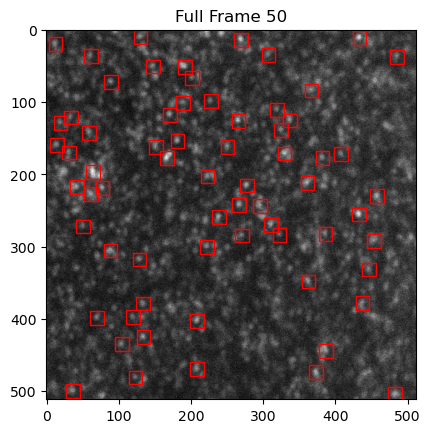

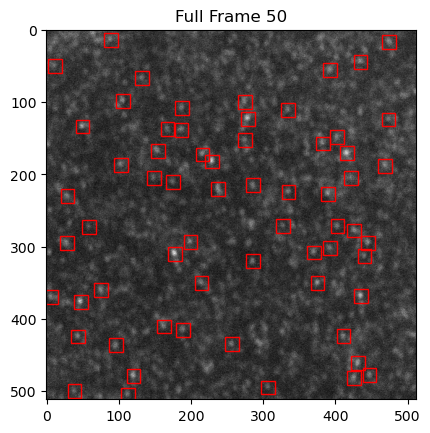

Produced 6598 PSFs for A647
Produced 27518 PSFs for CF660


In [50]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
indices = [50]

A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
print(f"Produced {len(A647_PSF_frames)} PSFs for A647")
print(f"Produced {len(CF660_PSF_frames)} PSFs for CF660")

(6598, 19, 19)


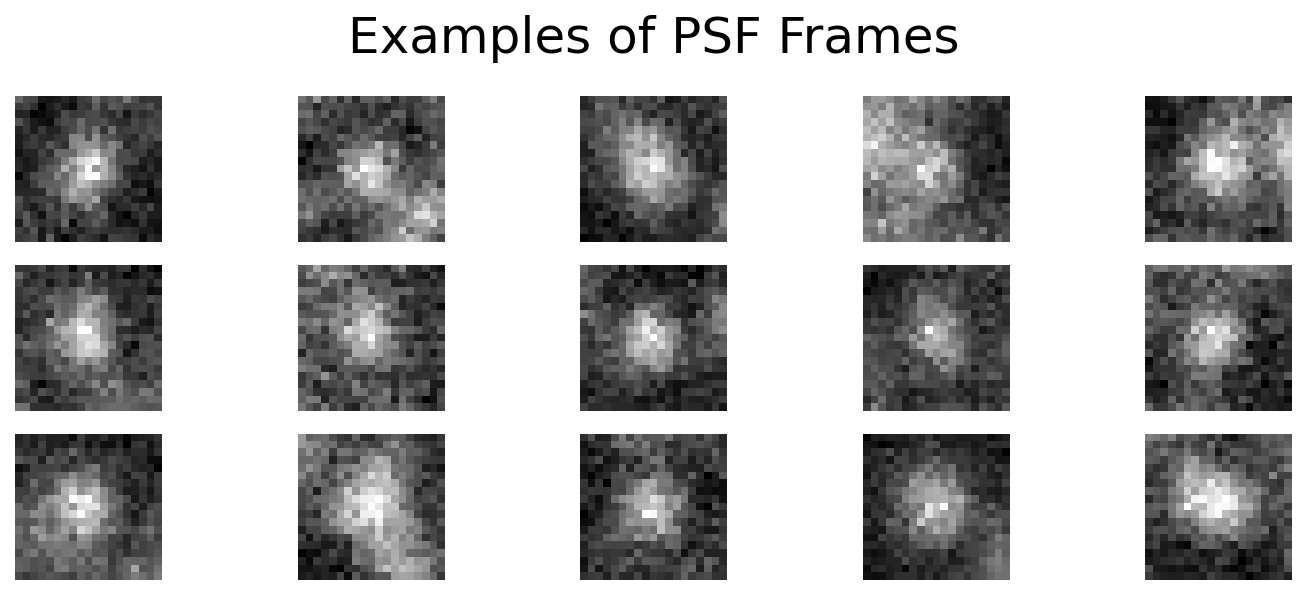

(27518, 19, 19)


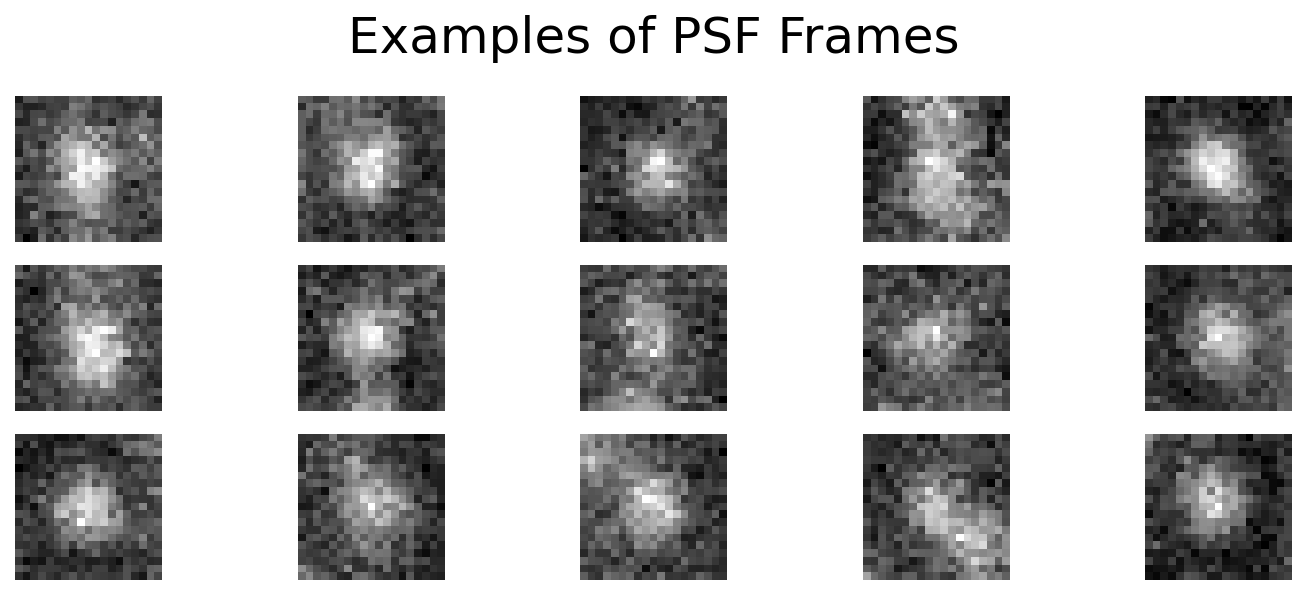

In [51]:
show_PSFs(A647_PSF_frames)
show_PSFs(CF660_PSF_frames)

In [52]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSF_frames
B_raw = CF660_PSF_frames

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [59]:
# make testing set
PSF_good_testing = PSFDataset(True, split=1)
print(len(PSF_good_testing))

13196


# Model Code

## Function Definitions

In [54]:
# model code for simple convolutional neural network
class CNN(nn.Module):
    # constructor
    def __init__(self, channel_widths, pooling, nonlinearity=nn.ReLU()):
        super(CNN, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            # convolution layer
            # you can play around with kernel_size, padding, and stride if you like
            # kernel_size is most likely to have an impact
            # arguments are: Conv2d(n_input_channels, n_output_channels, 
            #                       filter_side_length, padding, stride_length)
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
            layers.append(nonlinearity) # non-linearity
        # add final layer
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling # reduce each of the H x W feature maps to a single pooled value
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]
        self.linear = nn.Linear(channel_widths[-1]*self.pool_size, 2)  # score each class to obtain logits
    # forward pass
    def forward(self, x):
        B = x.size(0) # number of input images
        features = self.backbone(x) # get feature maps (B, N_feature_maps, H, W)
        pooled_features = self.global_pooling(features) # (B, N_feature_maps, 1, 1)
        pooled_features = pooled_features.view(B, -1) # (B, N_feature_maps)
        logits = self.linear(pooled_features) # (B, N_classes)
        return logits

In [55]:
# model code for simple convolutional nerual network followed by fully connected layers
class CNN_FC(nn.Module):
    # constructor
    def __init__(self, channel_widths, linear_sizes, pooling, nonlinearity=nn.ReLU()):
        super(CNN_FC, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
            layers.append(nonlinearity)
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]

        # Defining the fully connected layers
        fc_layers = []
        in_features = channel_widths[-1]*self.pool_size
        for size in linear_sizes:
            fc_layers.append(nn.Linear(in_features, size))
            fc_layers.append(nonlinearity)
            in_features = size
        self.fully_connected = nn.Sequential(*fc_layers)

        self.linear = nn.Linear(in_features, 2)  # score each class to obtain logits

    # forward pass
    def forward(self, x):
        B = x.size(0)
        features = self.backbone(x)
        pooled_features = self.global_pooling(features)
        pooled_features = pooled_features.view(B, -1)
        fc_output = self.fully_connected(pooled_features)
        logits = self.linear(fc_output)
        return logits

In [56]:
def train(model, all_data, training_indices, validation_indices, config, verbose=False):
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
    
    # training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)
        
def validate(model, dataloader, criterion):
    val_loss = 0
    val_acc = 0
    # set model to eval mode (again, unnecessary here but good practice)
    model.eval()
    # don't compute gradients since we are not updating the model, saves a lot of computation
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            val_loss += loss.item()
            val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return val_loss, val_acc

def test(model, dataset):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            test_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return test_acc/len(dataset)

# plot training/validation loss and accuracy over training time
def plot_model_results():
    plt.figure(figsize=(15, 10))
    plt.subplot(221)
    plt.semilogy(train_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Training loss')
    plt.grid(True)
    plt.subplot(222)
    plt.plot(train_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Training accuracy')
    plt.grid(True)
    plt.subplot(223)
    plt.plot(val_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Validation loss')
    plt.grid(True)
    plt.subplot(224)
    plt.plot(val_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Validation accuracy')
    plt.grid(True)

## Training and Testing

### Model 5

In [57]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 10000 # 100 examples per class
N_validation_examples = 5000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 32, 64, 128, 256, 256, 256] # must start with a 1 and be at least length--2
linear_sizes = [512, 256, 128, 64, 32]
model = CNN_FC(channel_widths, linear_sizes, pool_fcn)

In [58]:
config = {'lr': 1e-3,
          'n_epochs': 100,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 6.6763e-01, Acc = 0.5022, (Val) Loss = 6.6752e-01, Acc = 0.4916
Epoch 10/100: (Train) Loss = 6.4480e-01, Acc = 0.5847, (Val) Loss = 6.3942e-01, Acc = 0.6324
Epoch 15/100: (Train) Loss = 6.1309e-01, Acc = 0.6568, (Val) Loss = 6.0117e-01, Acc = 0.7414
Epoch 20/100: (Train) Loss = 5.7329e-01, Acc = 0.7032, (Val) Loss = 5.4483e-01, Acc = 0.7674
Epoch 25/100: (Train) Loss = 5.3561e-01, Acc = 0.7352, (Val) Loss = 4.8406e-01, Acc = 0.7990
Epoch 30/100: (Train) Loss = 4.8958e-01, Acc = 0.7651, (Val) Loss = 4.2926e-01, Acc = 0.8232
Epoch 35/100: (Train) Loss = 4.5172e-01, Acc = 0.7905, (Val) Loss = 4.1727e-01, Acc = 0.8336
Epoch 40/100: (Train) Loss = 4.2313e-01, Acc = 0.8117, (Val) Loss = 3.6643e-01, Acc = 0.8596
Epoch 45/100: (Train) Loss = 4.0307e-01, Acc = 0.8242, (Val) Loss = 3.8351e-01, Acc = 0.8198
Epoch 50/100: (Train) Loss = 3.8027e-01, Acc = 0.8379, (Val) Loss = 3.9878e-01, Acc = 0.8318
Epoch 55/100: (Train) Loss = 3.5977e-01, Acc = 0.8497, (Val) Loss = 3.1

0.8775851124252447
0.7321157926644438


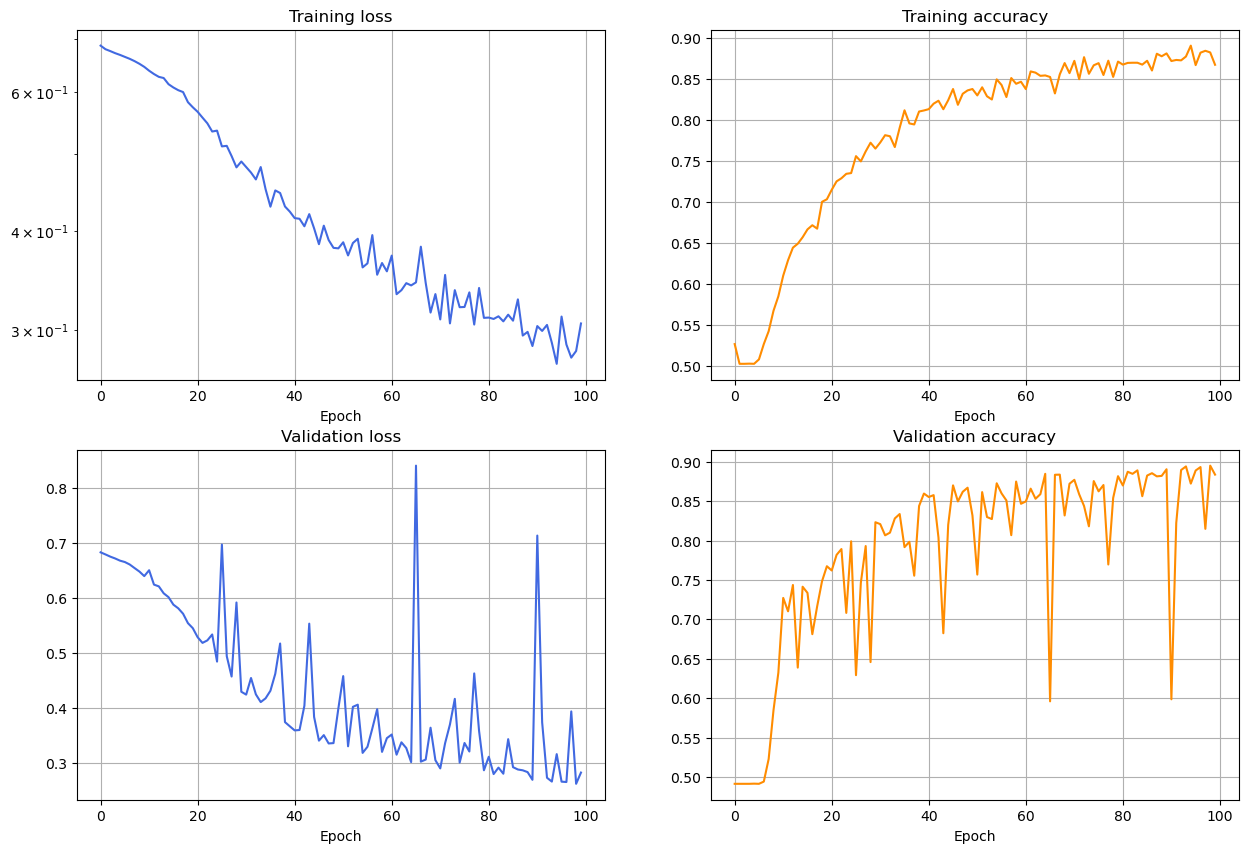

In [60]:
# plot training/validation loss and accuracy over training time
print(test(model, PSF_testing))
print(test(model, PSF_good_testing))
plot_model_results()

In [61]:
config = {'lr': 1e-4,
          'n_epochs': 100,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 2.3711e-01, Acc = 0.9064, (Val) Loss = 2.5503e-01, Acc = 0.8960
Epoch 10/100: (Train) Loss = 2.3272e-01, Acc = 0.9074, (Val) Loss = 2.5215e-01, Acc = 0.8960
Epoch 15/100: (Train) Loss = 2.2985e-01, Acc = 0.9084, (Val) Loss = 2.5129e-01, Acc = 0.8988
Epoch 20/100: (Train) Loss = 2.2774e-01, Acc = 0.9090, (Val) Loss = 2.5017e-01, Acc = 0.8972
Epoch 25/100: (Train) Loss = 2.2513e-01, Acc = 0.9105, (Val) Loss = 2.4938e-01, Acc = 0.8962
Epoch 30/100: (Train) Loss = 2.2296e-01, Acc = 0.9113, (Val) Loss = 2.5185e-01, Acc = 0.8936
Epoch 35/100: (Train) Loss = 2.2108e-01, Acc = 0.9112, (Val) Loss = 2.4931e-01, Acc = 0.8942
Epoch 40/100: (Train) Loss = 2.1852e-01, Acc = 0.9132, (Val) Loss = 2.4858e-01, Acc = 0.8958
Epoch 45/100: (Train) Loss = 2.1755e-01, Acc = 0.9132, (Val) Loss = 2.4967e-01, Acc = 0.8950
Epoch 50/100: (Train) Loss = 2.1496e-01, Acc = 0.9145, (Val) Loss = 2.4622e-01, Acc = 0.9000
Epoch 55/100: (Train) Loss = 2.1317e-01, Acc = 0.9167, (Val) Loss = 2.4

0.8960275299856336
0.7199151257956957


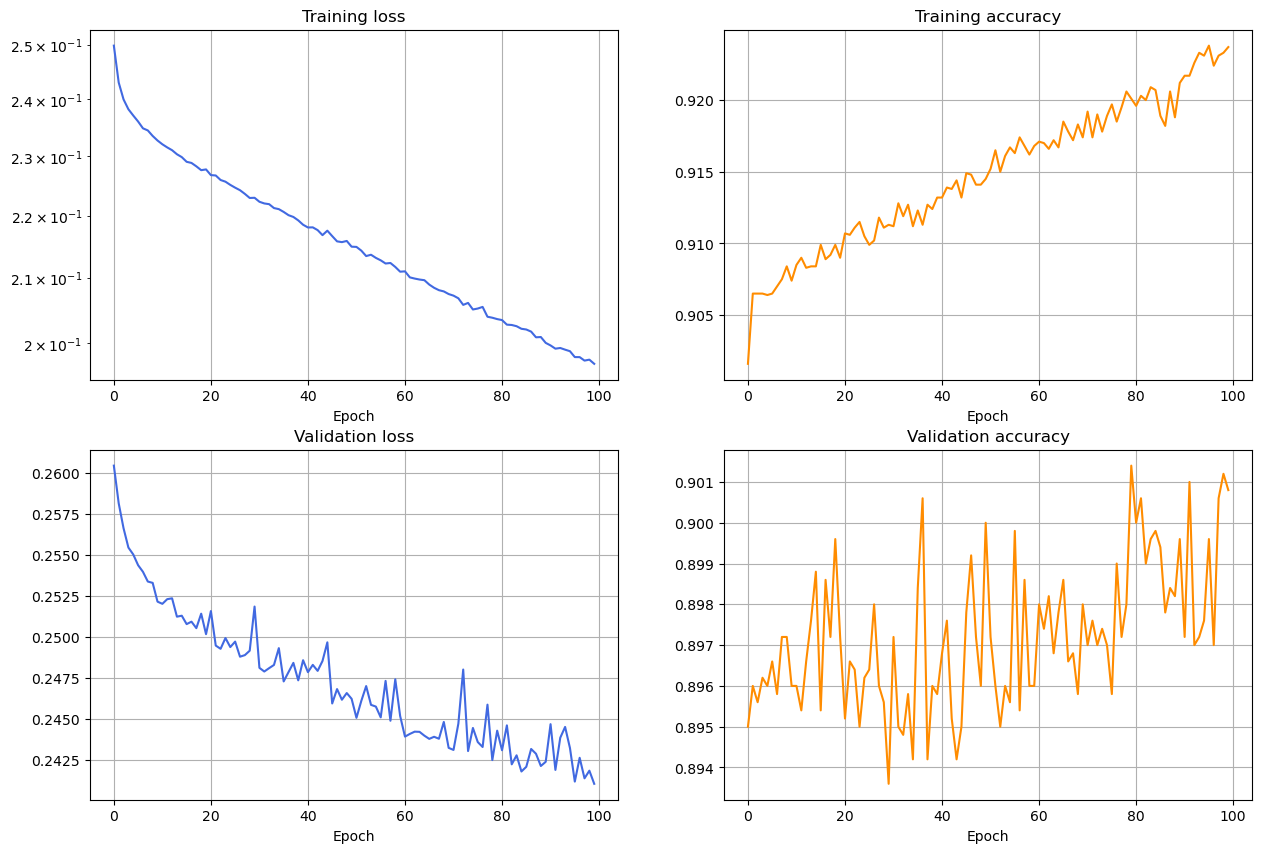

In [63]:
# plot training/validation loss and accuracy over training time
print(test(model, PSF_testing))
print(test(model, PSF_good_testing))
plot_model_results()
torch.save(model, 'Models/model5.pt')

### Model 6

In [65]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 10000 # 100 examples per class
N_validation_examples = 5000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 32, 64, 128, 256] # must start with a 1 and be at least length--2
linear_sizes = [256, 128, 64, 32]
model_6 = CNN_FC(channel_widths, linear_sizes, pool_fcn)

In [66]:
config = {'lr': 1e-3,
          'n_epochs': 100,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_6.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 6.4240e-01, Acc = 0.6093, (Val) Loss = 7.0307e-01, Acc = 0.5126
Epoch 10/100: (Train) Loss = 6.1243e-01, Acc = 0.6504, (Val) Loss = 5.6732e-01, Acc = 0.7092
Epoch 15/100: (Train) Loss = 5.7502e-01, Acc = 0.6913, (Val) Loss = 5.2822e-01, Acc = 0.7674
Epoch 20/100: (Train) Loss = 5.3748e-01, Acc = 0.7241, (Val) Loss = 4.7183e-01, Acc = 0.7938
Epoch 25/100: (Train) Loss = 4.8740e-01, Acc = 0.7623, (Val) Loss = 4.3692e-01, Acc = 0.8418
Epoch 30/100: (Train) Loss = 4.5373e-01, Acc = 0.7855, (Val) Loss = 3.9126e-01, Acc = 0.8448
Epoch 35/100: (Train) Loss = 4.1095e-01, Acc = 0.8157, (Val) Loss = 4.3817e-01, Acc = 0.7812
Epoch 40/100: (Train) Loss = 4.0256e-01, Acc = 0.8180, (Val) Loss = 3.5617e-01, Acc = 0.8538
Epoch 45/100: (Train) Loss = 3.7320e-01, Acc = 0.8364, (Val) Loss = 4.0581e-01, Acc = 0.8256
Epoch 50/100: (Train) Loss = 3.5447e-01, Acc = 0.8511, (Val) Loss = 3.2351e-01, Acc = 0.8614
Epoch 55/100: (Train) Loss = 3.5482e-01, Acc = 0.8452, (Val) Loss = 3.2

0.8743109151047409
0.7507578053955745


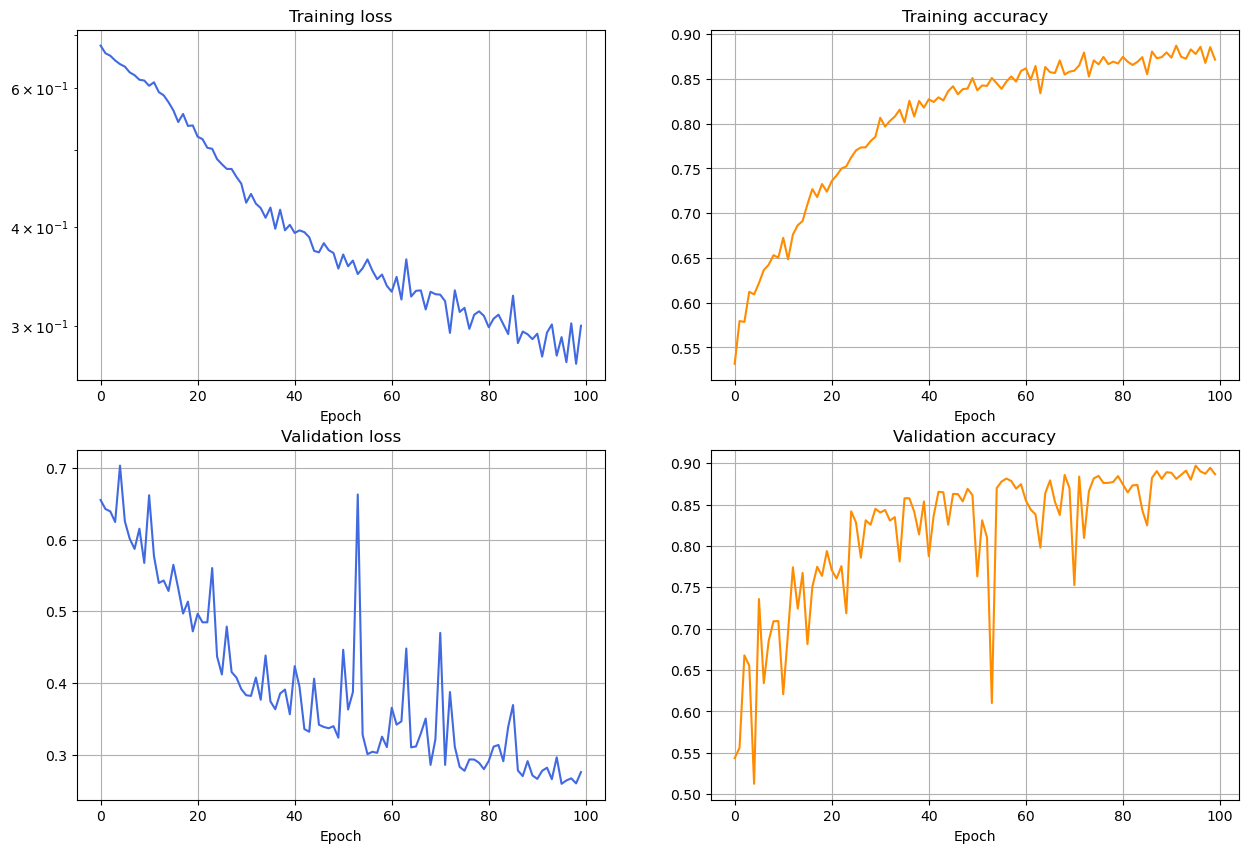

In [69]:
# plot training/validation loss and accuracy over training time
print(test(model_6, PSF_testing))
print(test(model_6, PSF_good_testing))
plot_model_results()

In [70]:
config = {'lr': 1e-4,
          'n_epochs': 100,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_6.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 2.3208e-01, Acc = 0.9081, (Val) Loss = 2.5176e-01, Acc = 0.8974
Epoch 10/100: (Train) Loss = 2.2843e-01, Acc = 0.9091, (Val) Loss = 2.4964e-01, Acc = 0.8960
Epoch 15/100: (Train) Loss = 2.2625e-01, Acc = 0.9115, (Val) Loss = 2.4977e-01, Acc = 0.8952
Epoch 20/100: (Train) Loss = 2.2419e-01, Acc = 0.9106, (Val) Loss = 2.4756e-01, Acc = 0.8984
Epoch 25/100: (Train) Loss = 2.2223e-01, Acc = 0.9122, (Val) Loss = 2.4853e-01, Acc = 0.8956
Epoch 30/100: (Train) Loss = 2.2047e-01, Acc = 0.9124, (Val) Loss = 2.4665e-01, Acc = 0.8980
Epoch 35/100: (Train) Loss = 2.1859e-01, Acc = 0.9140, (Val) Loss = 2.4551e-01, Acc = 0.8986
Epoch 40/100: (Train) Loss = 2.1677e-01, Acc = 0.9149, (Val) Loss = 2.4463e-01, Acc = 0.9000
Epoch 45/100: (Train) Loss = 2.1516e-01, Acc = 0.9143, (Val) Loss = 2.4618e-01, Acc = 0.8970
Epoch 50/100: (Train) Loss = 2.1346e-01, Acc = 0.9166, (Val) Loss = 2.4623e-01, Acc = 0.8968
Epoch 55/100: (Train) Loss = 2.1216e-01, Acc = 0.9161, (Val) Loss = 2.4

0.8935551769068858
0.7246892997878145


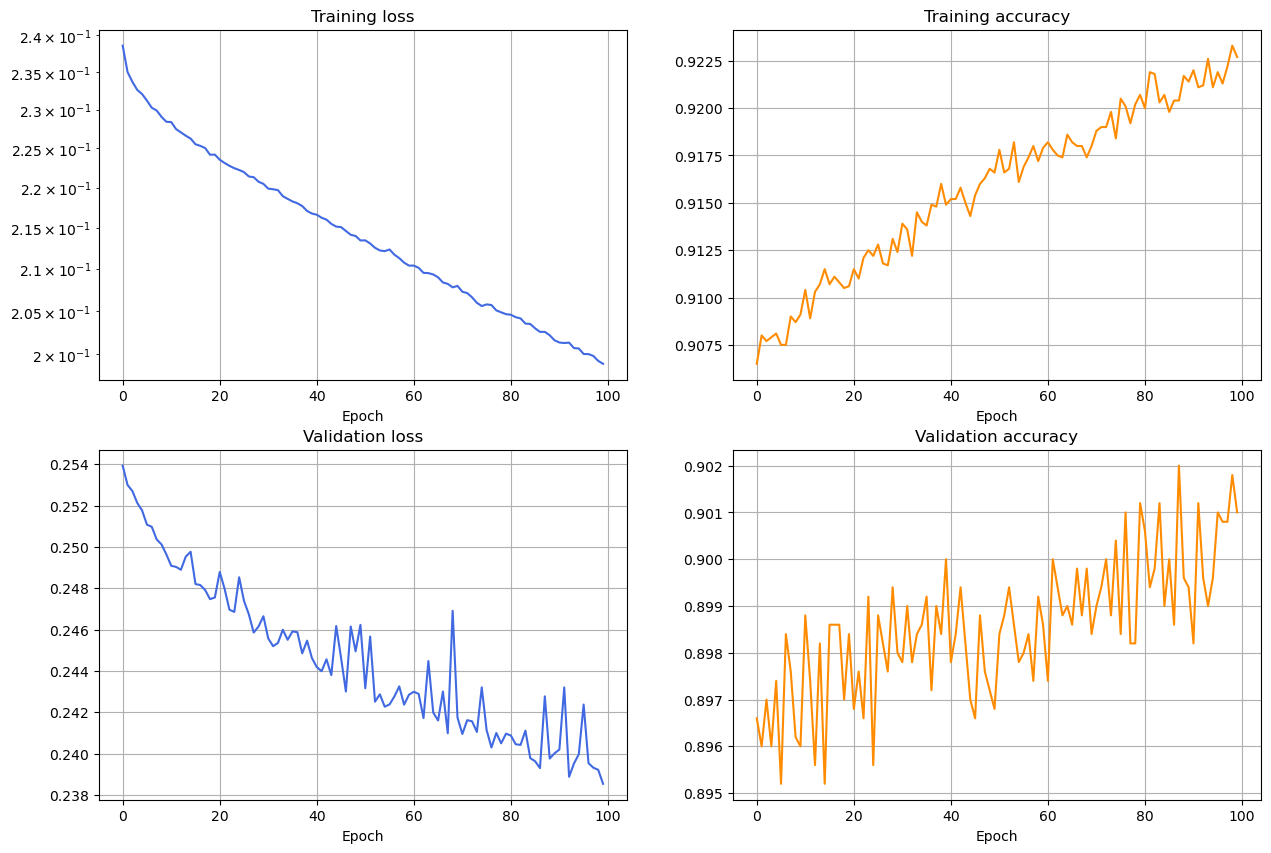

In [71]:
# plot training/validation loss and accuracy over training time
print(test(model_6, PSF_testing))
print(test(model_6, PSF_good_testing))
plot_model_results()

In [72]:
random_seed = 2 # Now we change the training and validation data subsets to try to improve unknown performance
np.random.seed(random_seed)

all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

config = {'lr': 1e-4,
          'n_epochs': 100,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_6.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 2.4347e-01, Acc = 0.9006, (Val) Loss = 2.5064e-01, Acc = 0.9020
Epoch 10/100: (Train) Loss = 2.3908e-01, Acc = 0.9003, (Val) Loss = 2.4877e-01, Acc = 0.9010
Epoch 15/100: (Train) Loss = 2.3442e-01, Acc = 0.9053, (Val) Loss = 2.4791e-01, Acc = 0.9018
Epoch 20/100: (Train) Loss = 2.3092e-01, Acc = 0.9059, (Val) Loss = 2.4732e-01, Acc = 0.9032
Epoch 25/100: (Train) Loss = 2.2760e-01, Acc = 0.9071, (Val) Loss = 2.4823e-01, Acc = 0.9040
Epoch 30/100: (Train) Loss = 2.2565e-01, Acc = 0.9073, (Val) Loss = 2.4653e-01, Acc = 0.9020
Epoch 35/100: (Train) Loss = 2.2219e-01, Acc = 0.9094, (Val) Loss = 2.4667e-01, Acc = 0.9062
Epoch 40/100: (Train) Loss = 2.1991e-01, Acc = 0.9098, (Val) Loss = 2.4408e-01, Acc = 0.9040
Epoch 45/100: (Train) Loss = 2.1784e-01, Acc = 0.9113, (Val) Loss = 2.4492e-01, Acc = 0.9046
Epoch 50/100: (Train) Loss = 2.1567e-01, Acc = 0.9112, (Val) Loss = 2.4381e-01, Acc = 0.9044
Epoch 55/100: (Train) Loss = 2.1272e-01, Acc = 0.9155, (Val) Loss = 2.4

0.9004710834920316
0.721354956047287


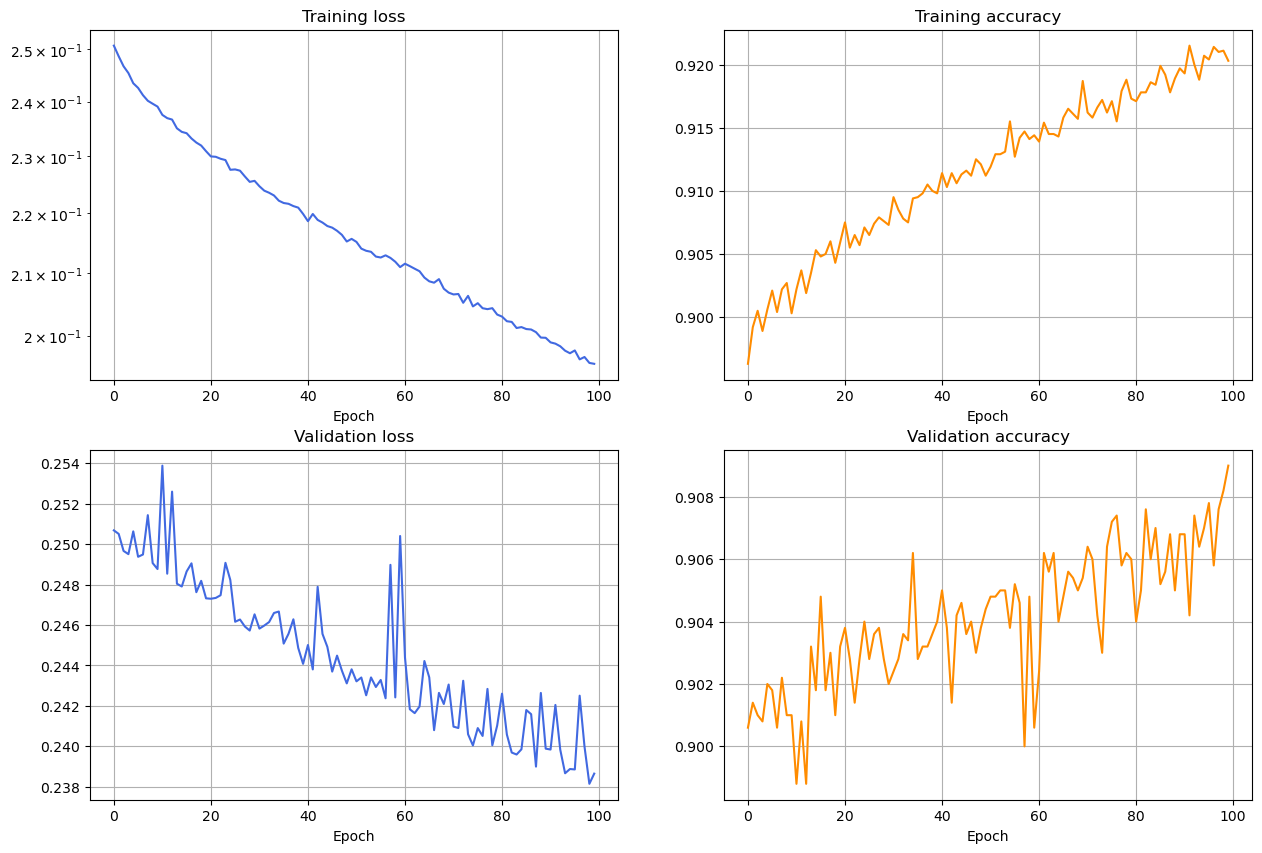

In [73]:
# plot training/validation loss and accuracy over training time
print(test(model_6, PSF_testing))
print(test(model_6, PSF_good_testing))
plot_model_results()

In [74]:
torch.save(model_6, 'Models/model6.pt')

### Model 7

In [75]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 50000 # 100 examples per class
N_validation_examples = 10000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 128, 128, 256, 256, 512] # must start with a 1 and be at least length--2
linear_sizes = [1024, 64]
model_7 = CNN_FC(channel_widths, linear_sizes, pool_fcn)

In [80]:
config = {'lr': 1e-2,
          'n_epochs': 10,
          'batch_size': 200}
# train
verbose = False # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_7.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

0.9167084293875915
0.7187026371627766


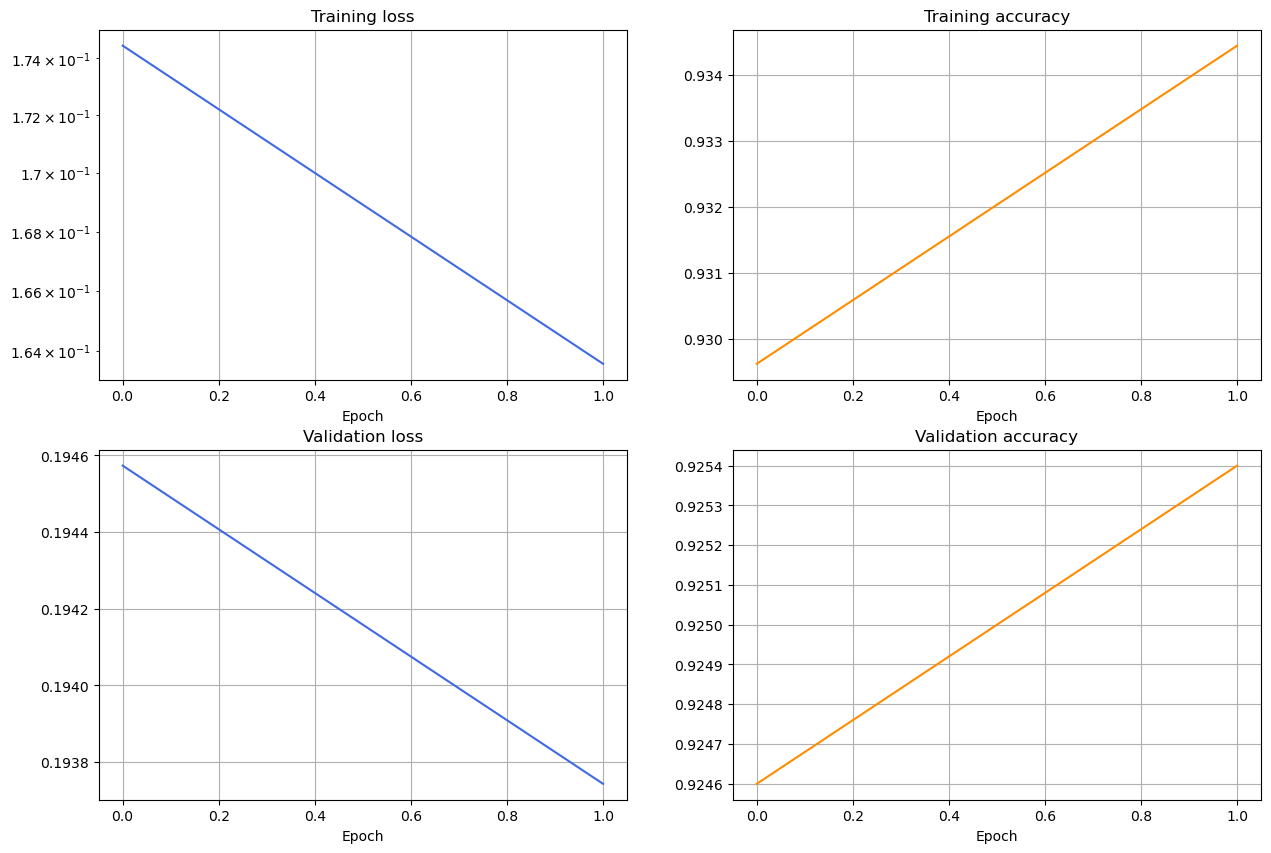

In [81]:
# plot training/validation loss and accuracy over training time
print(test(model_7, PSF_testing))
print(test(model_7, PSF_good_testing))
plot_model_results()

In [82]:
torch.save(model_7, 'Models/model7.pt')

### Model 8

In [84]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 50000 # 100 examples per class
N_validation_examples = 10000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 128, 128, 256, 256, 512] # must start with a 1 and be at least length--2
linear_sizes = [1024, 64]
model_8 = CNN_FC(channel_widths, linear_sizes, pool_fcn)

In [85]:
config = {'lr': 1e-3,
          'n_epochs': 20,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_8.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 6.4678e-01, Acc = 0.6003, (Val) Loss = 6.1002e-01, Acc = 0.6922
Epoch 2/20: (Train) Loss = 6.1088e-01, Acc = 0.6613, (Val) Loss = 5.9392e-01, Acc = 0.6034
Epoch 3/20: (Train) Loss = 5.7891e-01, Acc = 0.6924, (Val) Loss = 6.2279e-01, Acc = 0.6554
Epoch 4/20: (Train) Loss = 5.5719e-01, Acc = 0.7073, (Val) Loss = 4.8746e-01, Acc = 0.8150
Epoch 5/20: (Train) Loss = 5.2774e-01, Acc = 0.7313, (Val) Loss = 5.3027e-01, Acc = 0.7442
Epoch 6/20: (Train) Loss = 4.9991e-01, Acc = 0.7559, (Val) Loss = 4.2944e-01, Acc = 0.8366
Epoch 7/20: (Train) Loss = 4.8011e-01, Acc = 0.7673, (Val) Loss = 4.8989e-01, Acc = 0.7734
Epoch 8/20: (Train) Loss = 4.5024e-01, Acc = 0.7896, (Val) Loss = 6.1530e-01, Acc = 0.6046
Epoch 9/20: (Train) Loss = 4.5113e-01, Acc = 0.7891, (Val) Loss = 4.3721e-01, Acc = 0.7822
Epoch 10/20: (Train) Loss = 4.3225e-01, Acc = 0.8007, (Val) Loss = 4.0772e-01, Acc = 0.8264
Epoch 11/20: (Train) Loss = 4.0493e-01, Acc = 0.8195, (Val) Loss = 3.7396e-01, Acc = 0.83

0.830576993752297
0.6536829342224917


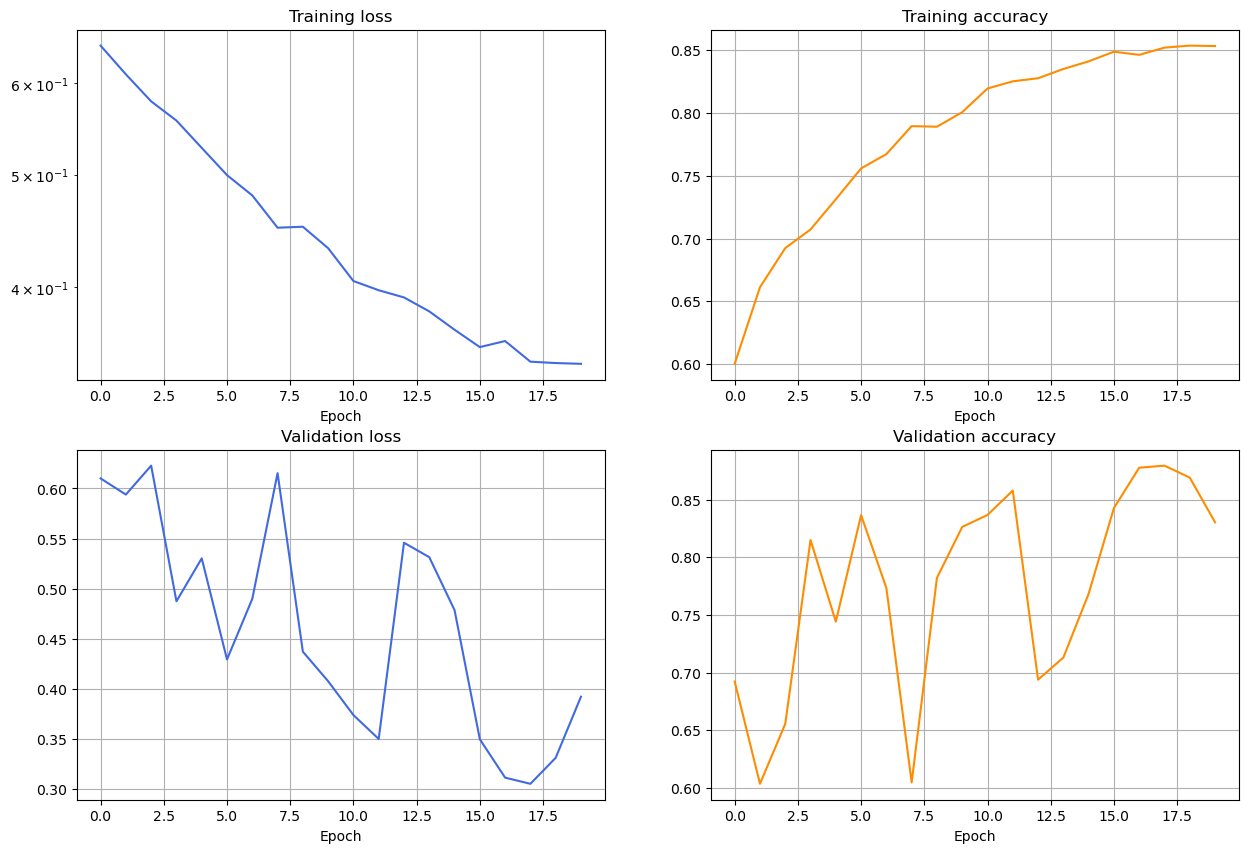

In [86]:
# plot training/validation loss and accuracy over training time
print(test(model_8, PSF_testing))
print(test(model_8, PSF_good_testing))
plot_model_results()

In [87]:
config = {'lr': 1e-3,
          'n_epochs': 20,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_8.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_2,
                                                                   config,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 3.3315e-01, Acc = 0.8605, (Val) Loss = 4.3481e-01, Acc = 0.7812
Epoch 2/20: (Train) Loss = 3.2861e-01, Acc = 0.8618, (Val) Loss = 2.9442e-01, Acc = 0.8774
Epoch 3/20: (Train) Loss = 3.2093e-01, Acc = 0.8653, (Val) Loss = 3.4622e-01, Acc = 0.8358
Epoch 4/20: (Train) Loss = 3.1057e-01, Acc = 0.8721, (Val) Loss = 3.5062e-01, Acc = 0.8580
Epoch 5/20: (Train) Loss = 3.0978e-01, Acc = 0.8716, (Val) Loss = 3.2052e-01, Acc = 0.8698
Epoch 6/20: (Train) Loss = 3.0113e-01, Acc = 0.8762, (Val) Loss = 3.0173e-01, Acc = 0.8810
Epoch 7/20: (Train) Loss = 2.9710e-01, Acc = 0.8771, (Val) Loss = 2.7888e-01, Acc = 0.8920
Epoch 8/20: (Train) Loss = 3.0746e-01, Acc = 0.8705, (Val) Loss = 2.8928e-01, Acc = 0.8716
Epoch 9/20: (Train) Loss = 3.1316e-01, Acc = 0.8683, (Val) Loss = 2.7322e-01, Acc = 0.8866
Epoch 10/20: (Train) Loss = 2.8769e-01, Acc = 0.8814, (Val) Loss = 3.1218e-01, Acc = 0.8556
Epoch 11/20: (Train) Loss = 2.8995e-01, Acc = 0.8806, (Val) Loss = 2.8456e-01, Acc = 0.87

0.8784871871972203
0.751364049712034


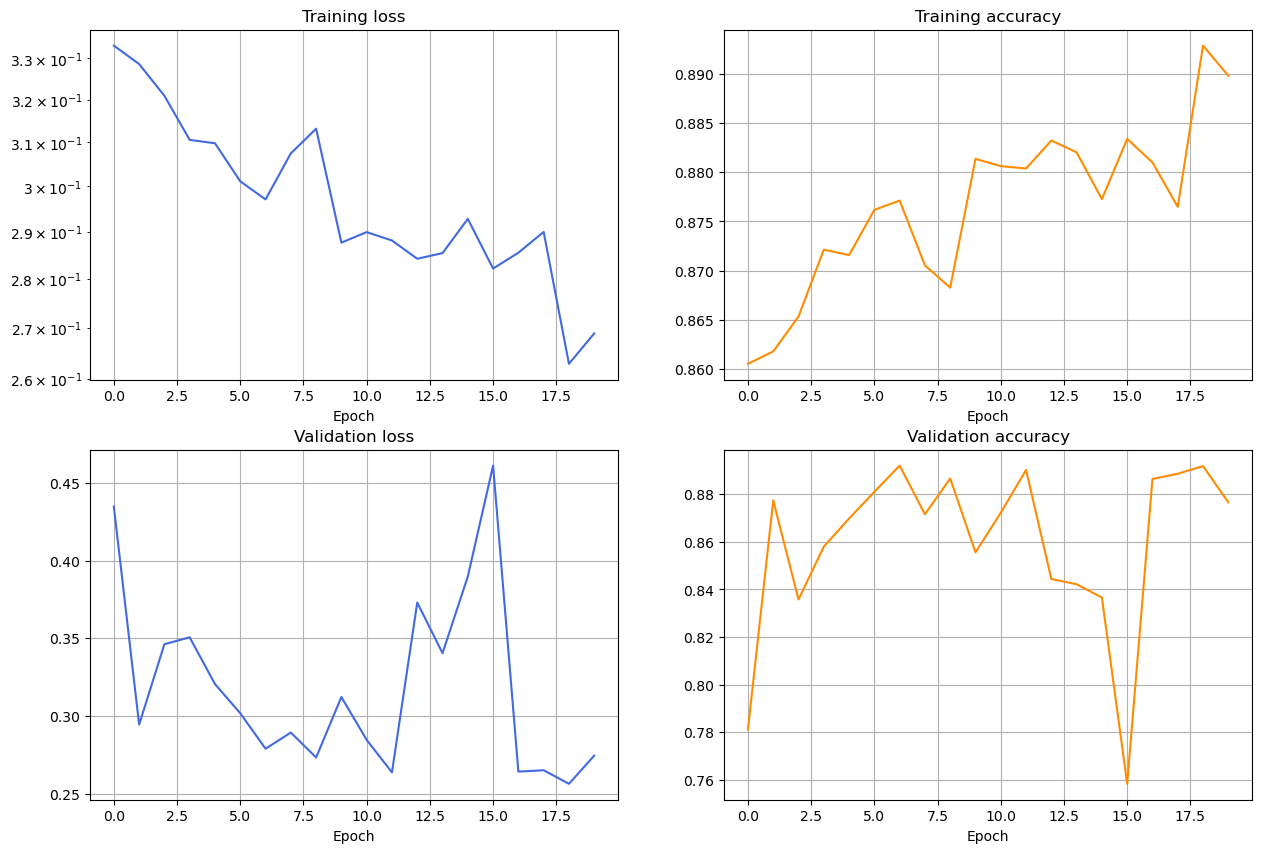

In [88]:
# plot training/validation loss and accuracy over training time
print(test(model_8, PSF_testing))
print(test(model_8, PSF_good_testing))
plot_model_results()

In [89]:
torch.save(model_8, 'Models/model8.pt')